In [1]:
from utils.data_loading import CombustionSystemDataset

PATH = 'Zare_data/combustion_img_13.mat'

test_data = CombustionSystemDataset(PATH,'test_set_x','test_set_y')
train_data = CombustionSystemDataset(PATH,'train_set_x','train_set_y')

In [2]:
index = 200
image = test_data.data[index]
label = test_data.labels[index]

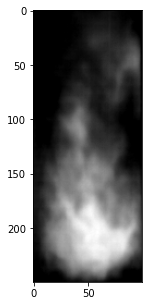

In [3]:
import numpy as np
import matplotlib.pyplot as plt

test_image = np.resize(image,(250,100))
plt.figure(figsize=(10,5))
plt.imshow(test_image, cmap='gray')
plt.show()

In [4]:
from torch.utils.data import DataLoader,random_split

ratio = 0.8
train_size = round(len(train_data) * .8)
val_size = len(train_data) - train_size
train, validation = random_split(train_data, [train_size,val_size])
# train, validation,_ = random_split(train_data, [128,128,len(train_data)-256])

In [5]:
batch_size = 128
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation,batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
import torch
import torch.nn as nn
from model.decoder import Decoder
from model.encoder import Encoder
from model.autoencoder import AE

In [8]:
from utils.trainer import training
from utils.tester import testing

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AE(Encoder, Decoder)
model.to(device)  # Move the model to the GPU
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
epochs=10
train_losses, validation_losses = training(model, criterion, optimizer, train_dataloader, validation_dataloader, epochs, device)
# testing(model,criterion,test_dataloader,device)

Epoch 2/10, Loss_train: 909.8162, validation_loss: 940.6436, Time taken: 14.58934 seconds
Epoch 4/10, Loss_train: 505.0389, validation_loss: 942.9909, Time taken: 14.57985 seconds
Epoch 6/10, Loss_train: 447.6662, validation_loss: 907.4406, Time taken: 14.59260 seconds
Epoch 8/10, Loss_train: 418.9253, validation_loss: 957.6848, Time taken: 14.49289 seconds
Epoch 10/10, Loss_train: 404.9567, validation_loss: 808.6710, Time taken: 14.54766 seconds


<function part2.utils.trainer.training(model, criterion, optimizer, train_loader, validation_loader, epochs, device)>

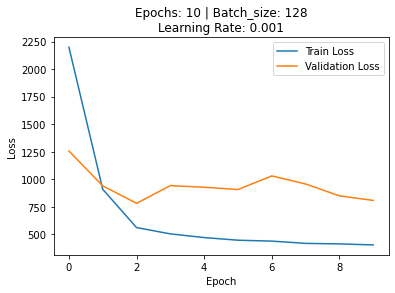

In [19]:
loss_title = "Epochs: " + str(epochs) + " | Batch_size: " + str(batch_size) + "\nLearning Rate: 0.001"
plt.title(loss_title)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(train_losses,label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.show()

In [20]:
model.to('cpu')
for images, target in test_dataloader:
   output =  model(images)
   break

In [21]:
con_image = output.detach().numpy()[20]
ri_image = images.detach().numpy()[20]

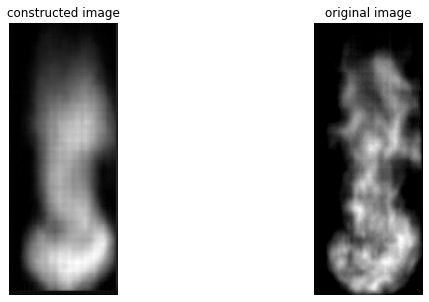

In [22]:
import matplotlib.pyplot as plt

# Assuming con_image[0] and con_image[1] are the images you want to display
image1 = con_image[0]
image2 = ri_image[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a 1x2 grid of subplots
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('constructed image')  # Replace 'Label 1' with the desired label for the first image
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].set_title('original image')  # Replace 'Label 2' with the desired label for the second image
axes[1].axis('off')

plt.show()


In [23]:
torch.save(model.state_dict(), './logging/model.pth')